# Set up environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Check CUDA version is >= 12.1
import torch

cuda_version = torch.version.cuda
if cuda_version is None:
    print("CUDA not available")
else:
    major, minor = map(int, cuda_version.split('.')[:2])
    if major < 12 or (major == 12 and minor < 1):
        raise RuntimeError(f"CUDA version {cuda_version} detected. Version 12.1 or later is required due to known bugs with torch.fft.fft in earlier versions.")
    else:
        print(f"CUDA version {cuda_version} detected - OK")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA version 12.1 detected - OK


In [3]:
# import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

# Set random seed
utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

Here we use simulated data from exponetial integrate-and-fire (EIF) neuron model. For using Allen Institute's visual coding data, please check out the other notebook "Allen_multi_session_dataloader.ipynb"

In [5]:
######### Simulation Settings #########
# Parameters for external input to neurons
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",  # Type of input pattern
        # two_peaks_with_all_varying means both the peak times and background dynamics are varying
    "std1": 10,                # Standard deviation of first peak
    "corr1": 0.5,             # Correlation coefficient for first peak between two populations
    "std2": 25,               # Standard deviation of second peak
    "corr2": 0.5,             # Correlation coefficient for second peak between two populations
    "gp_time_constant": 300,   # Time constant for background dynamics as a Gaussian Process
    "gp_amplitude": 0.1,       # Amplitude of the background dynamics Gaussian Process fluctuations
}

# Neural population parameters
conn = 0.1                    # Cross-area mean synaptic weight
nneuron_coupling = 10         # Number of neurons having cross-area synapses 
                              # (involved in cross-area coupling)
nneuron = 100                 # Total number of neurons
nneuron_part = nneuron//2     # Number of neurons in each area/population
npadding = 50                 # Padding length for time series
############################

# Run neural network simulation. Note that the output spike trains have bin size = 2ms. 
spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
    ntrial=2000,              # Number of trials to simulate
    nneuron=nneuron,         # Total number of neurons
    conn=conn,                # Connection strength
    nneuron_coupling=nneuron_coupling,  # Number of connections per neuron
    params=external_input_params,        # Input parameters
    return_trial_info=True,   # Return trial metadata
    return_I_ext=True,        # Return external currents
    return_I_syn=True,        # Return synaptic currents
)

# Print memory usage of spike array; be careful don't use too many trials and blow up the memory
print(f"Size of spikes array in MB: {spikes.nbytes / (1024 * 1024):.2f} MB")


100%|██████████| 2000/2000 [02:48<00:00, 11.87it/s]

Size of spikes array in MB: 457.76 MB


In [6]:
print(f"The spikes trains has shape: {spikes.shape} \
(number of time bins, number of neurons, number of trials)")

The spikes trains has shape: (300, 100, 2000) (number of time bins, number of neurons, number of trials)


Mean firing rate: 30.973 Hz


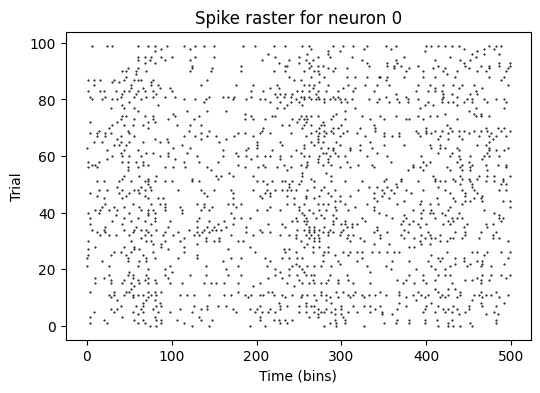

In [7]:
# Let's look at the spike trains from one neuron in different trials
neuron_idx = 0  # Choose one neuron

plt.figure(figsize=(6,4))
for trial in range(100):  # Plot first 200 trials
    spike_times = np.where(spikes[npadding:,neuron_idx,trial])[0]*2
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')
print(f"Mean firing rate: {spikes[:,neuron_idx, :].mean()*500:.3f} Hz")

In [8]:
# Create a dataloader for the synthetic spike data. 
# Simple_dataloader_from_spikes takes in a list of 
# [numpy spike train array of popuation 1, numpy spike train array of popuation 2]

synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],  
        # Split spikes into two populations (first and second half of neurons)
    npadding=50,        # Use 50 time bins of padding at start
    train_ratio=0.7,    # Use 70% of trials for training
    val_ratio=0.1,      # Use 10% of trials for validation (for early-stop); remaining 20% for held-out testing
    batch_size=64,      # Process 64 trials at a time as a batch during training
    verbose=True
)

Now we get the data and dataloader ready! Let's start training GLM-Transformer

# Train a model

In [9]:
data_to_use = synthetic_dataloader
ckp_path = './GLMTransformer_checkpoint' # Model checkpoint path
verbose = False

params = {
    # B-spline basis parameters
    'num_B_spline_basis': 20,  # Number of B-spline basis functions to use for individual-neuron component
    
    # Transformer VAE architecture settings
    'downsample_factor': 10,    # How many bins to merge as one token.
                                # e.g., 10 means a token is ten original bins, 
                                # so the bin length for a token is 10*2ms=20ms
    'transformer_num_layers': 2, # Number of Transformer encoder layers
    'transformer_d_model': 128,  # Dimension of Transformer model
    'transformer_dim_feedforward': 512,  # Dimension of feedforward layer in Transformer
    'transformer_vae_output_dim': 16,    # Total dimension of VAE latent space 
                # = "number of areas" * "dimension of VAE latent space PER AREA"
                # must be evenly divisible by "number of areas"
    'transformer_dropout': 0.0,  # Dropout probability in Transformer
    'transformer_nhead': 1,      # Number of attention heads
    'stimulus_nfactor': 1,       # Number of factors in individual-neuron component
    'stimulus_decoder_inter_dim_factor': 2,  # Multiplier for decoder hidden layer dimension
                # This decoder takes in VAE's latent and outputs B-spline basis coefficients
                # and only has one hidden layer
    'beta': 1.0,                 # Weight of KL divergence term in VAE loss
    'use_area_specific_decoder': True,  # Whether to use separate decoders for each brain area
        # If True, the area-specific decoder would look at $z^{a,i}$, where i stands for area i
        # If False, the global decoder would look at $z^{a}$
    'use_area_specific_encoder': True,  # Whether to use separate encoders for each brain area
        # If True, the area-specific encoder 
        # If False, the global encoder for each area would look at spike trains from all areas
    'use_cls': False,            # Whether to use CLS token as in BERT; 
                                # If False, it uses average pooling instead of CLS token
    
    # Cross-area coupling parameters
    'coupling_basis_peaks_max': 5,  # Time lag for the last/latest basis peak (in bins)
    'coupling_basis_num': 3,        # Number of coupling basis functions
    'coupling_nsubspace': 1,        # Dimension of coupling factor
    'use_self_coupling': True,      # Whether to include self-coupling terms
    
    # Self-history parameters (for modeling single-neuron's post-spike effects )
    'self_history_basis_peaks_max': 1.5,  # Time lag for the last/latest basis peak (in bins)
    'self_history_basis_num': 2,         # Number of self-history basis functions
    'self_history_basis_nonlinear': 1,   # Number of nonlinear basis functions
    
    # Regularization parameters
    'penalty_smoothing_spline': 1e2,   # Penalty for B-spline smoothness
    'penalty_coupling_subgroup': 1e-5,  # L1 Penalty for loading weights
    
    # Training hyperparameters
    'batch_size': 64,            # Number of trials per batch
    'sample_latent': False,      # Whether to sample from approximate posterior distribution during training
    'epoch_warm_up': 0,          # Number of warm-up epochs
    'epoch_patience': 3,         # Patience for early stopping (number of epochs without improvement)
    'epoch_max': 200,            # Maximum number of epochs
    'tol': 1e-5,                # Tolerance for early stopping
    'weight_decay': 0,          # L2 regularization weight
    'lr_transformer': 1e-4,     # Learning rate for individual-neuron effect encoder (the Transformer)
    'lr_sti': 1e-2,            # Learning rate for individual-neuron effect decoder
    'lr_cp': 1e-2,             # Learning rate for cross-area coupling parameters
    'lr_self_history': 1e-2,   # Learning rate for self-history parameters
}

trainer = Trainer(data_to_use, ckp_path, params)

# First step: train the model with a trial-invariant individual-neuron effect
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=True,
    verbose=verbose,
)

# Second step: train the model with a trial-varying individual-neuron effect
trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
trainer.train(
    include_stimulus=True,
    include_coupling=False,
    fix_stimulus=False,
    verbose=verbose,
)

# Third step: train the model with a trial-varying individual-neuron effect and cross-area coupling
trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
trainer.train(
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    verbose=verbose,
)

# Fourth step: train the model with a trial-varying individual-neuron effect, cross-area coupling, and self-history
trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
    'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
    'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
trainer.train(
    include_stimulus=True,
    include_coupling=True,
    include_self_history=True,
    fix_stimulus=False,
    verbose=verbose,
    record_results=True,
)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda


 44%|████▎     | 87/200 [00:20<00:27,  4.15it/s]
/home/qix/GLM-Transformer/model_trainer.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(tor

0.2290962404342153

In [10]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )

test_loss /= total_trial
print(f"Test loss: {test_loss}")

100%|██████████| 7/7 [00:00<00:00, 62.05it/s]

Test loss: 0.23176402786277475


/tmp/ipykernel_1302462/2722292062.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


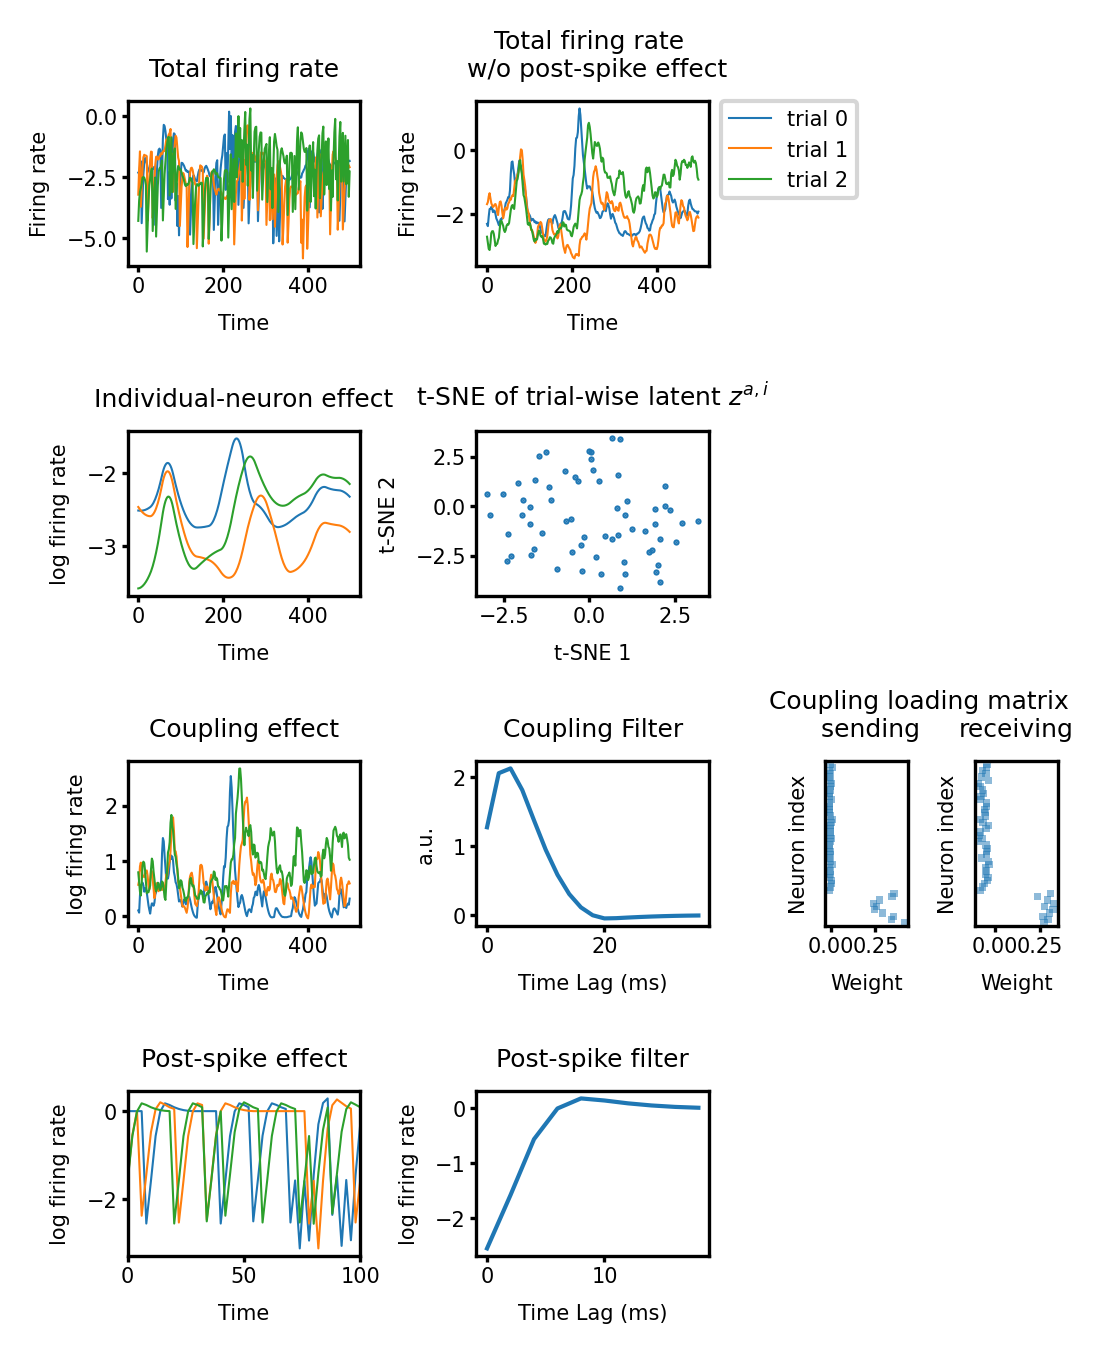

In [11]:
# Now let's look at the model's prediction and each components
# Select a few trials to visualize
local_trial_indices = np.arange(0, 3) # Select first 5 trials in the test set batch
# Select one neuron to visualize
neuron_idx = 51 # The first neuron in the second population

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
    dataset='test', # Select the test set
    batch_indices=[0], # Select the first batch in the test set
    include_stimulus=True, # Include the individual-neuron effect
    include_coupling=True, # Include the cross-area coupling effect
    include_self_history=True, # Include the self-history effect
    fix_stimulus=False, # Do not fix the individual-neuron / use trial-varying individual-neuron effect
    return_torch=True, # Return the results in torch tensor
    return_trial_indices=True, # Return the trial indices in the original global trial list
    return_spike_trains=True, # Return the spike trains
)

# Create a subplot figure
utils.use_pdf_plot()
fig = plt.figure(figsize=(4, 5), dpi=300)
outer = GridSpec(4, 3, figure=fig, wspace=0.5, hspace=1)
axes = np.empty((4, 3), dtype=object)
for i in range(4):
    for j in range(3):
        if (i, j) not in [(0,2), (1,2), (2,2), (3,2)]:  # we'll manually insert subpanels here
            axes[i, j] = fig.add_subplot(outer[i, j])

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[0, 0].plot(
        xx,
        firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy(),
        linestyle='-',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'trial {trial_idx}',
        lw=0.5,
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Plot total firing rate without post-spike effect
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[0, 1].plot(
        xx,
        (
            firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy()
            - trainer.model.self_history_outputs[trial_idx, neuron_idx, :].cpu().numpy()
        ),
        linestyle='-',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'trial {trial_idx}',
        lw=0.5,
    )
axes[0, 1].set_title('Total firing rate \n w/o post-spike effect')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Firing rate')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot individual-neuron effect
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[1, 0].plot(
        xx,
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        linestyle='-',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'trial {trial_idx}',
        lw=0.5,
    )
axes[1, 0].set_title('Individual-neuron effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')

# Plot t-SNE of the trial-wise latent $z^{a,i}$
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    print(f"Only one dimension")
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            marker='.',
            s=1,
            color='tab:blue',
        )
    axes[1, 1].set_title('t-SNE of trial-wise latent $z^{a,i}$')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )


# Plot coupling effects
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[2, 0].plot(
        xx,
        trainer.model.coupling_outputs[0][1][trial_idx, neuron_idx-nneuron_part, :].cpu().numpy(),
        linestyle='-',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
axes[2, 0].set_title('Coupling effect')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('log firing rate')

# Plot coupling filter
xxx = np.arange(trainer.model.coupling_filters_dict["0"][0][1].detach().cpu().numpy().shape[0])*2
axes[2, 1].plot(xxx,
               trainer.model.coupling_filters_dict["0"][0][1].detach().cpu().numpy(),
               label='Fitted', color='tab:blue')
axes[2, 1].set_title('Coupling Filter')
axes[2, 1].set_xlabel('Time Lag (ms)')
axes[2, 1].set_ylabel('a.u.')
# axes[2, 1].legend()

# Plot coupling loading matrix
inner = GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[2, 2], hspace=0.3, wspace=0.8
)
sub_ax1 = fig.add_subplot(inner[0])
sub_ax2 = fig.add_subplot(inner[1])
utils.plot_single_factor_loading_horizontal(
    sub_ax1,
    None,
    trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(),
    title="              Coupling loading matrix \n sending", 
    sort=False,
)
utils.plot_single_factor_loading_horizontal(
    sub_ax2,
    None,
    trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(),
    title="receiving", 
    sort=False,
)


# Plot post-spike effect
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[3, 0].plot(
        xx,
        trainer.model.self_history_outputs[trial_idx, neuron_idx, :].cpu().numpy(),
        linestyle='-',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
axes[3, 0].set_title('Post-spike effect')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('log firing rate')
axes[3, 0].set_xlim(0, 100)

# post-spike filter
xxx = np.arange(trainer.model.self_history_filters_dict["0"].detach().cpu().numpy().shape[0])*2
axes[3, 1].plot(xxx,
               trainer.model.self_history_filters_dict["0"].detach().cpu().numpy()[:, neuron_idx],
               label='Fitted', color='tab:blue')
axes[3, 1].set_title('Post-spike filter')
axes[3, 1].set_xlabel('Time Lag (ms)')
axes[3, 1].set_ylabel('log firing rate')
# axes[3, 1].legend()

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


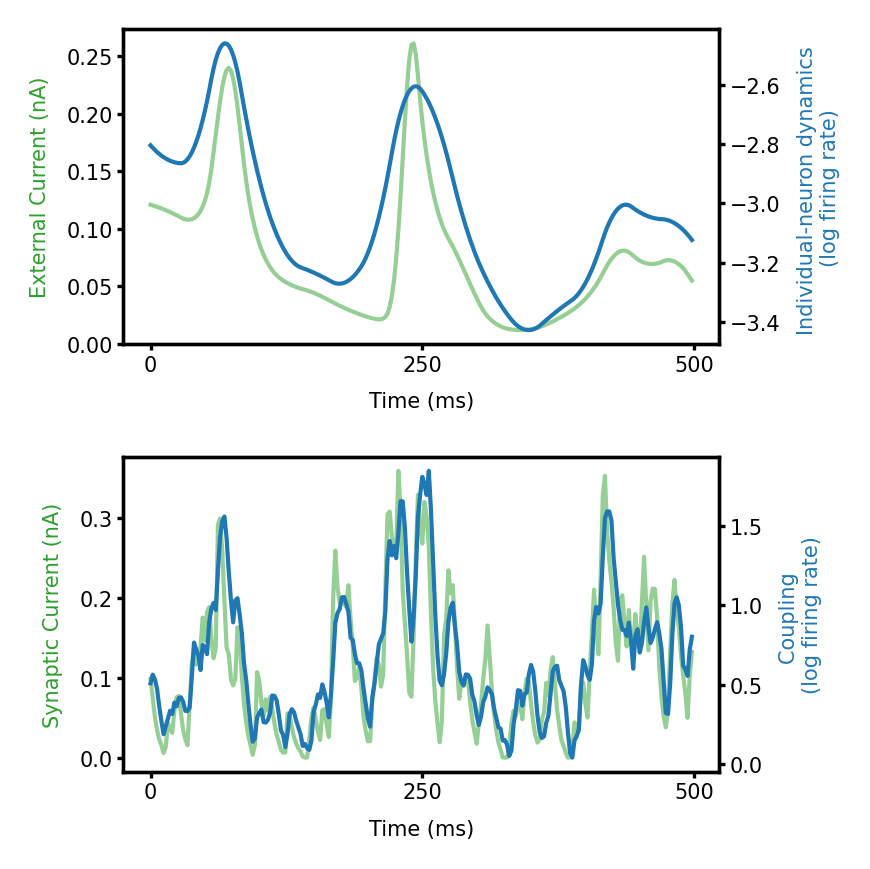

In [12]:
# Now let's compare each components of GLM-Transformer with the ground truth current. They are qualitatively similar. 
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 1, figsize=(3, 3), dpi=300)
log_fr_change = np.log(2) # Show log firing rate in 1ms, not the 2ms bin width
trial_idx = 20
original_trial_idx = trial_indices[trial_idx]
neuron_idx = 55

# Let's first compare the individual-neuron effects and the external input current. 
# Note that trainer.model.firing_rates_stimulus has shape 
# (number of trials, number of neurons, number of 2-ms time bins)
# But I_ext has shape 
# (number of 0.2-ms time bins including padding, number of neurons, number of trials)
ax = axes[0]
firing_rates_stimulus_to_plot = trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy()
I_ext_to_plot = I_ext[::10,neuron_idx,original_trial_idx][npadding:]

# Plot I_ext
ax.plot(xx, I_ext_to_plot, 'tab:green', alpha=0.5, label='I_ext')
ax.set_ylabel('External Current (nA)', color='tab:green')
ax.set_xlabel('Time (ms)')
# ax.legend(loc='upper left')
# ax.set_ylim(-0.07, 0.31)
ax.set_xticks([0, 250, 500])

# Plot firing rates with separate y-axis
ax2 = ax.twinx()
ax2.plot(xx, firing_rates_stimulus_to_plot -log_fr_change, 'tab:blue', label='r')
ax2.set_ylabel('Individual-neuron dynamics \n(log firing rate)', color='tab:blue')
ax2.tick_params(axis='y')
# ax2.set_ylim(-3.8-log_fr_change, -1.7-log_fr_change)
# ax2.legend(loc='upper right')


# Let's then compare the cross-population coupling effects and the cross-population synaptic current. 
ax = axes[1]
firing_rates_coupling_to_plot = trainer.model.firing_rates_coupling[trial_idx, neuron_idx, :].cpu().numpy()
I_syn_to_plot = I_syn[:,neuron_idx,original_trial_idx][npadding:]

# Plot I_syn
ax.plot(xx, I_syn_to_plot, 'tab:green', alpha=0.5, label='I_syn')
ax.set_ylabel('Synaptic Current (nA)', color='tab:green')
ax.set_xlabel('Time (ms)')
# ax.set_ylim(-0.018, 0.15+0.015*2)
ax.set_xticks([0, 250, 500])
# ax.legend(loc='upper left')

# Plot coupling rates with separate y-axis
ax2 = ax.twinx()
ax2.plot(xx, firing_rates_coupling_to_plot, 'tab:blue', label='r')
ax2.set_ylabel('Coupling \n(log firing rate)', color='tab:blue')
ax2.tick_params(axis='y')
# ax2.set_ylim(-0.025, 0.25+0.025*2)
# ax2.legend(loc='upper right')

plt.tight_layout()